# Evaluating Large Language Models using LLM-as-a-Judge with Amazon Bedrock

This notebook serves as a base for evaluating Large Language Models using LLM-as-a-Judge with Amazon Bedrock. 

>  This notebook should work well with the Data Science 3.0 kernel in SageMaker Studio


Evaluating large language models (LLM) is challenging due to their broad capabilities and the inadequacy of existing benchmarks in measuring human preferences. To address this, strong LLMs are used as judges to evaluate these models on more open-ended questions. The agreement between LLM judges and human preferences has been verified by introducing two benchmarks: [Multi Turn (MT)-bench](https://github.com/lm-sys/FastChat/tree/main/fastchat/llm_judge/data/mt_bench), a multi-turn question set, and [Chatbot Arena](https://arena.lmsys.org/), a crowdsourced battle platform. The results reveal that strong LLM judges can match both controlled and crowdsourced human preferences well, achieving over 80% agreement, the same level of agreement between humans. This makes LLM-as-a-judge a scalable and explainable way to approximate human preferences, which are otherwise very expensive to obtain.

> ℹ️  **Note:** The evaluation steps in this lab are based on the paper  [Judging LLM-as-a-Judge with MT-Bench and Chatbot Arena](https://arxiv.org/pdf/2306.05685.pdf).

This lab addresses this challenge by providing a practical solution for evaluating LLMs using LLM-as-a-Judge with Amazon Bedrock.  This is relevant for developers and researchers working on evaluating LLM based applications. In the notebook you are guided using MT-Bench questions to generate test answers and evaluate them with a single-answer grading using the Bedrock API, Python and Langchain. For demonstration purpose of this lab Claude Instant is evaluated and Claude 3 Sonnet is used as strong LLM judge. The notebook consists of the following chapters: 

1) [Setup of the environment](#1.-Setup-of-the-enviroment)
2) [Load MT-Bench questions](#2.-Load-MT-Bench-questions)
3) [Generate test answers from LLM which should be evaluated](#3.-Generate-test-answers-from-LLM-which-should-be-evaluated)
4) [Evaluate answers with strong LLM-as-a-judge](#4.-Evaluate-answers-with-strong-LLM-as-a-judge)
5) [Generate explanation for average rating score](#5.-Generate-explanation-for-average-rating-score)

## 1. Setup of the enviroment

We start by installing the required libraries.

In [2]:
%%capture 
%pip install langchain==0.1.10 boto3 tqdm

## 2. Load MT-Bench question set

This lab uses the MT-Bench questions set which consists of 80 high-quality multi-turn questions. They are designed to test multi-turn conversation and instruction-following ability, covering common use cases and focusing on challenging questions to differentiate models.

To evaluate custom applications or fine tuned LLMs, questions should be adjusted or created according to the use cases. They should focus on covering common uses cases and usage patterns.

We download the questions to use them for evaluation.

In [3]:
# Import necessary libraries
import requests
import json

# Download MT-Bench questions
url = "https://raw.githubusercontent.com/lm-sys/FastChat/main/fastchat/llm_judge/data/mt_bench/question.jsonl"
response = requests.get(url)
lines = response.text.split("\n") 

# Iterate through lines and append them to questions array as json
questions = []
for line in lines:
  if line:
    questions.append(json.loads(line))

## 3. Generate test answers from LLM which should be evaluated

Now that we have the questions stored, we use the LLM which should be evaluated to generate the answers to these questions. First we create a prompt template which we use in a second step to generate each answer.

In [4]:
# Import necessary libraries
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import BedrockChat
import boto3

# Create bedrock client
boto3_bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')

In [5]:
# Create a prompt template to generate a question a end-user could have about each open ended question
initial_question_prompt_template = PromptTemplate(
    input_variables=["input","history"],
    template="""HUMAN:
    <role>You are an artificial intelligence assistant and answer questions from a curious user</role>
    <task> Give a helpful, detailed, and polite answers to the user's question</task> 
    
    Current conversation:
    <conversation_history>
    {history}
    </conversation_history>
    
    Here is the human's next reply:
    <human_reply>
    {input}
    </human_reply>

    ANSWER:""")

In [6]:
# For each model provider there are different parameters to define when inferencing against the model. These depend on the use case.
inference_modifier = {
                        "temperature": 0.5,
                        "top_k": 250,
                        "top_p": 1,
                    }
                     

evaluate_llm = BedrockChat(model_id = "anthropic.claude-instant-v1",
                    client = boto3_bedrock, 
                    model_kwargs = inference_modifier 
                    )

In [7]:
# Import necessary libraries
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationChain
from tqdm.auto import tqdm

ℹ️  **Note:** The next steps takes several minutes to complete.

In [8]:
# Create evaluation answers
for question in tqdm(questions):
    memory = ConversationBufferMemory(memory_key="history", return_messages=True, ai_prefix="A", human_prefix="H")
    conversation = ConversationChain(llm=evaluate_llm, verbose=False, memory=memory)
    conversation.prompt = initial_question_prompt_template
    question['answers'] = []
    for turn in question['turns']:
        question['answers'].append(conversation.invoke(input=turn))

  0%|          | 0/80 [00:00<?, ?it/s]

## 4. Evaluate answers with strong LLM-as-a-Judge

In this step we use the strong LLM-as-a-Judge for evaluation.

Keep mind there are certian biases and limitations to this approach:
- Position bias refers to the tendency of LLMs used as judges, to be influenced by the position or order of information presented to them.
- Verbosity bias refers to the tendency of LLMs used as judges, to prefer verbose or overly long responses, even when a more concise answer would be more appropriate.
- Self-enhancement bias refers to the tendency of LLMs used as judges, to evaluate or present themselves in a more favorable light, even if it may not align with reality.

These limitations have to be taken into consideration when creating custom questions, creating the prompt templates, and choosing a LLM-as-a-Judge.
However, despite these limitations the agreement between LLM judges and humans is high.

First we create a prompt template the generate a ranking score from 0..10 and an explanation. In the second step, we calculate the average ranking score, display the distribution of ranking scores, and an overall explanation of the average score.


In [9]:
# Create a prompt template to generate a ranking and an explanation.
eval_prompt_template = PromptTemplate(
    input_variables=["question1","answer1","question2","answer2"],
    template="""HUMAN:
    <role>Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below.</role>
    <task>Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of the response. Your evaluation should focus on the assistant's answer to the second user question. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, you must rate the response on a scale of 1 to 10 by strictly following this format: \"<rating></rating>\", for example: \"Rating: <rating>5</rating>\</task> 
    
    <user_assistant_conversation>
        Human:
        <question_1>
        {question1}
        </question_1>

        Assistant:
        <answer_1>
        {answer1}
        </answer_1>

        Human:
        <question_2>
        {question2}
        </question_2>

        Assistant:
        <answer_2>
        {answer2}
        </answer_2>
    </user_assistant_conversation>

    ANSWER:""")

In [10]:
# For each model provider there are different parameters to define when inferencing against the model. These depend on the use case.
eval_inference_modifier = {
                        "temperature": 0.5,
                        "top_k": 250,
                        "top_p": 1,
                    }
                     

eval_llm = BedrockChat(model_id = "anthropic.claude-3-sonnet-20240229-v1:0",
                    client = boto3_bedrock, 
                    model_kwargs = inference_modifier 
                    )

ℹ️  **Note:** The next steps takes several minutes to complete.

In [11]:
# Evaluate previous generated answers
import re
amount_questions = 0
ratings_add_up = 0
reg_str = "<rating>(.*?)</rating>"
explanation_rating = []
for question in tqdm(questions):
    question1 = question['answers'][0]['input']
    question2 = question['answers'][1]['input']
    answer1 = question['answers'][0]['response']
    answer2 = question['answers'][1]['response']
    question['rating_text'] = eval_llm.invoke(eval_prompt_template.format(question1 = question1, answer1 = answer1, question2=question2, answer2=answer2)).content
    tag_value = re.search(reg_str, question['rating_text'])
    if tag_value: 
        question['rating_score'] = tag_value.group(1)
        explanation_rating.append(question['rating_text'])
        amount_questions = amount_questions + 1
        ratings_add_up = ratings_add_up + int(question['rating_score'])

  0%|          | 0/80 [00:00<?, ?it/s]

In [12]:
# Calculate the average rating score
average_rating = ratings_add_up/amount_questions
print("The average rating score is: {}".format(average_rating))

The average rating score is: 8.6125


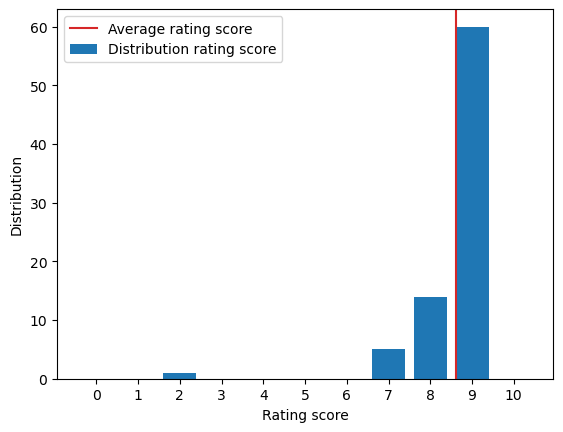

In [13]:
# Diplay rating scores in bar chart
import matplotlib.pyplot as plt
from operator import countOf

rating_scores = []
for question in questions:
    if 'rating_score' in question: 
        rating_scores.append(question['rating_score'])

bar_labels = []
rating_scores_count = []

for x in range(11):
    bar_labels.append(str(x))
    rating_scores_count.append(countOf(rating_scores,str(x)))

fig, ax = plt.subplots()
ax.bar(bar_labels, rating_scores_count)
ax.set_ylabel('Distribution')
ax.set_xlabel('Rating score')
plt.axvline(x=average_rating, color='tab:red')
plt.legend(['Average rating score','Distribution rating score'])
plt.show()


## 5. Generate explanation for average rating score

To explain the average rating score, each rating explanation can be used to create a summary and identiy areas for improvements to further optimize the application.

In [14]:
# Define prompt to summarize all ratings to explain the given average rating
summary_prompt_template = """HUMAN:
<role>Please act as an impartial summarizer and summarize the following explanations from a LLM as a judge to one single statement</role>
<task>Explain the main areas for improvement. Also, write a concise summary of the following explantions from a LLM as a judge to explain the average rating given which the LLM as judge gave. </task>

<average_rating>{average_rating}</average_rating>
<explanations>{explanations}</explanations>
ANSWER:"""
summary_prompt = PromptTemplate.from_template(summary_prompt_template)

In [15]:
explanation_avg_rating = eval_llm.invoke(summary_prompt.format(average_rating=average_rating, explanations=explanation_rating)).content

In [16]:
print(explanation_avg_rating)

Based on the explanations provided, the main areas for improvement seem to be:

1. Providing more concise summaries or conclusions at times to reinforce the key points.
2. Expanding on certain aspects with additional details, examples, or context where relevant.
3. Analyzing complexities like time/space complexity, alternative approaches, or potential limitations in more depth for some technical responses.

As for the average rating of 8.6125 given by the LLM judge, the explanations suggest that the assistant's responses were generally of high quality, demonstrating strong understanding, accuracy, relevance, and helpfulness in addressing the given tasks or questions. The judge commended the assistant's creativity, level of detail, clear explanations, and ability to provide well-reasoned and insightful solutions across a diverse range of topics and scenarios. However, there were occasional opportunities for improvement in areas like conciseness, depth of analysis, and considering additi

## Conclusion

The lab demonstrates a practical approach for evaluating large language models (LLMs) using the LLM-as-a-Judge technique with Amazon Bedrock. This method addresses the challenges in evaluating LLMs due to their broad capabilities and the limitations of existing benchmarks in measuring human preferences.

By leveraging strong LLM judges, such as Claude 3 Sonnet in this notebook, the lab showcases how to assess the performance of LLMs like Claude Instant on the Multi Turn (MT)-Bench, a benchmark designed to measure alignment with human preferences. 

This approach makes LLM-as-a-judge a scalable and explainable way to approximate human preferences, which are otherwise very costly to obtain. The notebook provides a step-by-step guide on setting up the environment, loading the MT-Bench questions, generating test answers from the LLM under evaluation, leveraging the Bedrock API to assess the answers using the LLM judge, and visualize the results.

The successful demonstration of this LLM-as-a-Judge methodology with Amazon Bedrock demonstrates the potential for developers and researchers working on LLM-based applications to adopt this innovative evaluation technique. By understanding the alignment of their models with human preferences, they can make more informed decisions and continue to improve the capabilities of these powerful language models.